# Surface Mass Balance 

Import relevant Libaries 

In [1]:
%pip install pyarrow
%pip install plotly
%pip install feature_engine
%pip update pandas

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
ERROR: unknown command "update"
Note: you may need to restart the kernel to use updated packages.


In [1]:
# Base libraries
import pandas as pd
import numpy as np
import os
import math as math
import datetime
from scipy import stats

# Visualizations
import matplotlib.pyplot as plt

import plotly.express as px
import plotly.graph_objects as go

import seaborn as sns

Set WD

In [2]:
import os
from pyrsistent import v
os.getcwd()
#os.chdir('/Users/asgerlyngeholst-hansen/Desktop/GEUS-Master-Thesis/')
#os.chdir('C:\\Users\\nifu18ab\\Desktop\\GEUS-Master-Thesis')
#os.chdir('/Users/nilsfulde/Desktop/GEUS-Master-Thesis')
os.chdir('/Users/nilsfulde/Desktop/Master_Thesis')

**Load New Promice Data**

#Function for loading data and converting to datetime 
def load_promice(path_to_file):
    '''
    Loading PROMICE data for a given path into a DataFrame.
    + adding time index
    
    INTPUTS:
        path_to_file: Path to the desired file containing PROMICE data [string]
    
    OUTPUTS:
        df: Dataframe containing PROMICE data for the desired settings [DataFrame]
    '''

    df = pd.read_parquet(path_to_file, engine='pyarrow')
    df['time'] = pd.to_datetime(df.time, utc=True)
    df = df.set_index('time')
    return df




df = load_promice('data/new_promice/all_promice_data_hourly.parquet.gzip')

#### Load KM_L 

In [3]:
df = pd.read_csv('data/KAN_L.csv')

# add headers
header = pd.read_csv('metadata/promice_header.csv', sep = ";")
df = df.rename(columns = header.set_index('standard_name')['units']) # Headers are shifted in csv file

# add delta column 
df['Surface height from combined measurements DELTA'] = df['Surface height from combined measurements'].diff()

In [5]:
# This bit to add a beginning, middle & end of melting season attribute
beginning = 0.15
end = 0.85

# Iterate over each year
df["Datetime"] = pd.to_datetime(df["Datetime"], format="%Y-%m-%d %H:%M:%S")

for year in df['Datetime'].dt.year.unique():
    
    print("Calculating" , year)
    
    # Get the dataframe for the current year
    year_df = df[df['Datetime'].dt.year == year]
    
    # Determine the threshold values for the beginning and end of the melting season
    ablation_df = year_df[year_df['Ablation'] == True]
    lower_threshold = ablation_df['Datetime'].dt.dayofyear.quantile(beginning)
    upper_threshold = ablation_df['Datetime'].dt.dayofyear.quantile(end)
    
    # Set the Melting Season value for each row in the current year
    for index, row in year_df.iterrows():
        
        if row['Ablation'] == True:
            if row['Datetime'].dayofyear <= lower_threshold:
                df.loc[index, 'Melting Season'] = 'beginning'
            elif row['Datetime'].dayofyear >= upper_threshold:
                df.loc[index, 'Melting Season'] = 'end'
            else:
                df.loc[index, 'Melting Season'] = 'middle'
        else:
            df.loc[index, 'Melting Season'] = ''

Calculating 2008
Calculating 2009
Calculating 2010
Calculating 2011
Calculating 2012
Calculating 2013
Calculating 2014
Calculating 2015
Calculating 2016
Calculating 2017
Calculating 2018
Calculating 2019
Calculating 2020
Calculating 2021
Calculating 2022
Calculating 2023


In [6]:
# This bit to plot the Melting seasons
def plt_srf_height(input_df = df, y = df['Surface height from combined measurements'], Period = "All"):
    df = input_df
    
    if Period == "All":
        df = df
    else:
        start_date = Period[0]
        end_date = Period[1]
        df = df[df['Datetime'].between(start_date,end_date)]
    
    # Define the colors for the melting season categories
    colors = {'': 'black', 'beginning': 'green', 'middle': 'orange', 'end': 'red'}
        
    # Define the x-axis and y-axis values
    x = df['Datetime']
    y = y

    # Create a figure and axis object
    fig, ax = plt.subplots(figsize=(25, 10))

    # Iterate over the melting season categories
    for category in ['', 'beginning', 'middle', 'end']:

        # Get the indices where the Melting Season column matches the current category
        indices = df[df['Melting Season'] == category].index

        # Plot a scatter plot for the current category
        ax.scatter(x[indices], y[indices], color=colors[category], alpha=0.7, label=category)

    # Add a legend to the plot
    ax.legend()

    # Shade areas with "Ablation" = True
    ablation_mask = df["Ablation"]
    ablation_starts = df["Datetime"][ablation_mask & ~ablation_mask.shift(1, fill_value=False)]
    ablation_ends = df["Datetime"][ablation_mask & ~ablation_mask.shift(-1, fill_value=False)]
    for start, end in zip(ablation_starts, ablation_ends):
        ax.axvspan(start, end, color="yellow", alpha=0.2)

    # Set the title and axis labels
    ax.set_title(pd.DataFrame(y).columns.to_list()[0])
    ax.set_xlabel('Date')
    ax.set_ylabel('Surface Height (m)')

    # Show the plot
    plt.show()

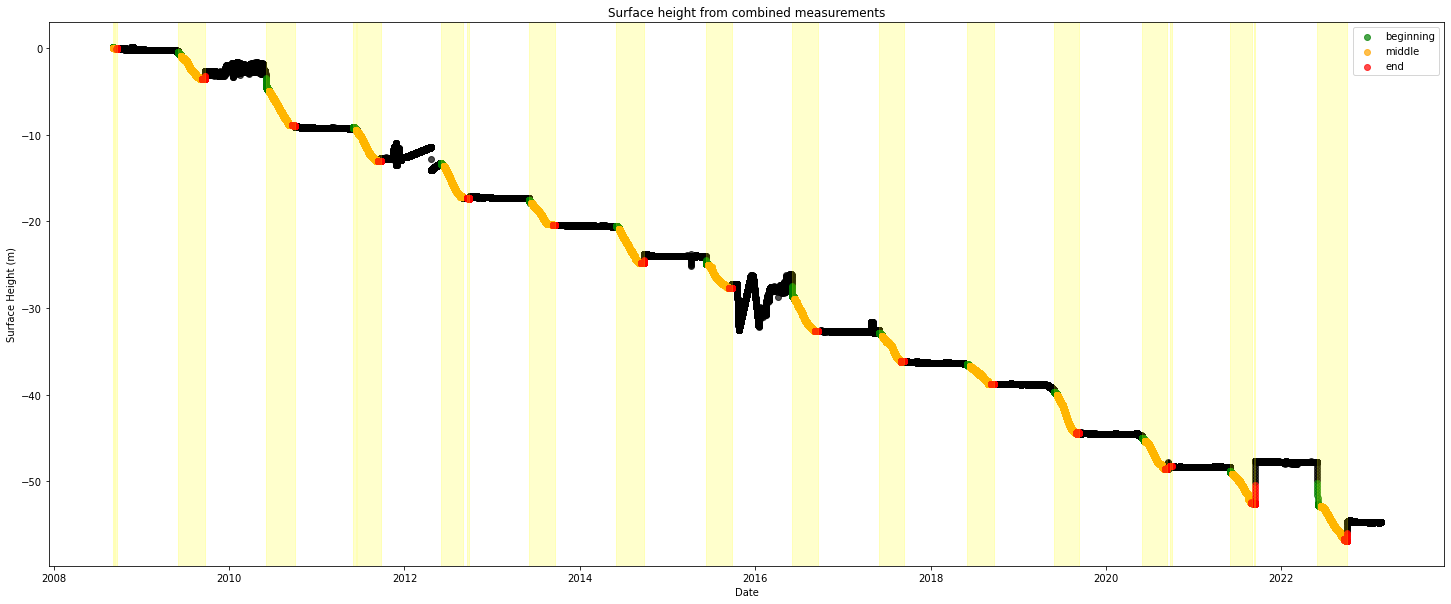

In [7]:
plt_srf_height()

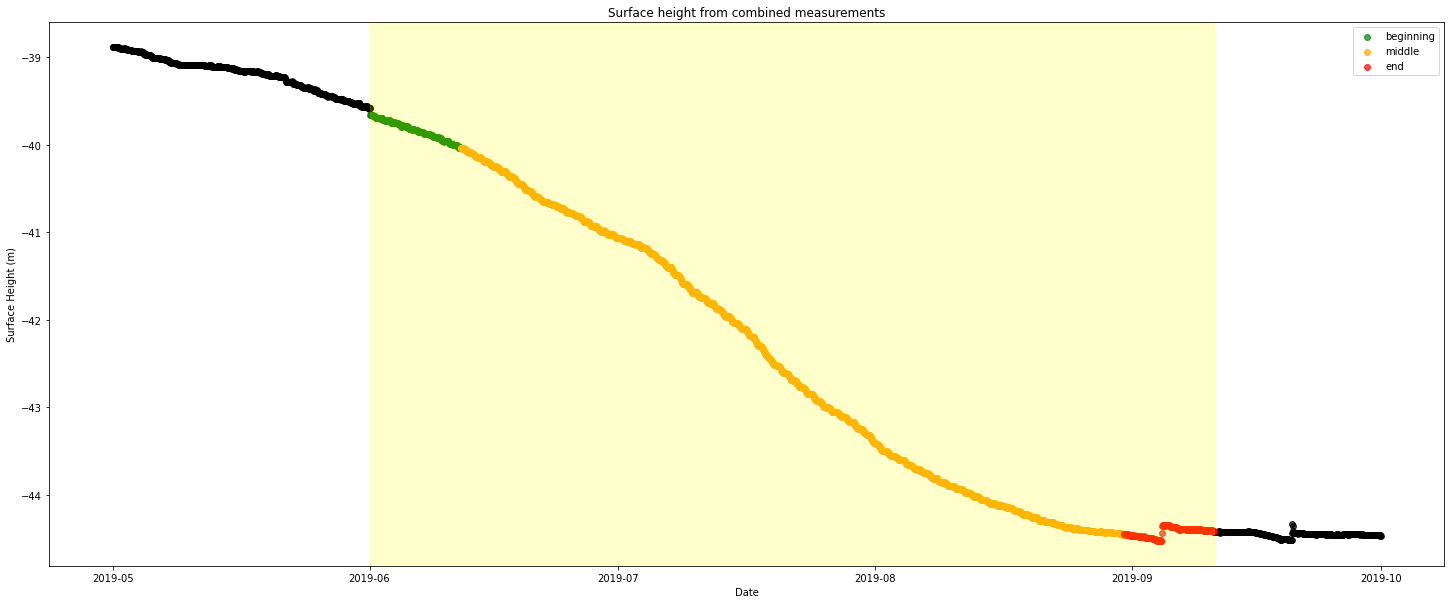

In [14]:
# Zooming in on a specific period
plt_srf_height(Period = ["2019-05-01", "2019-10-01"])

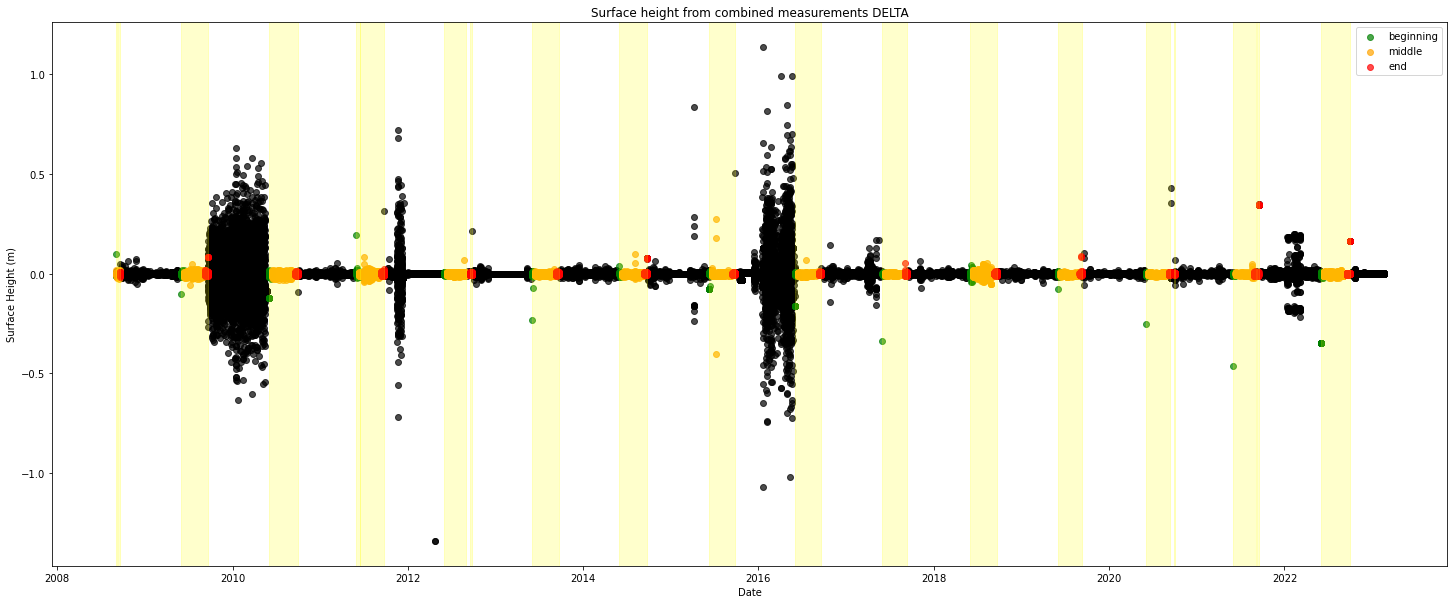

In [9]:
plt_srf_height(y = df['Surface height from combined measurements DELTA'])

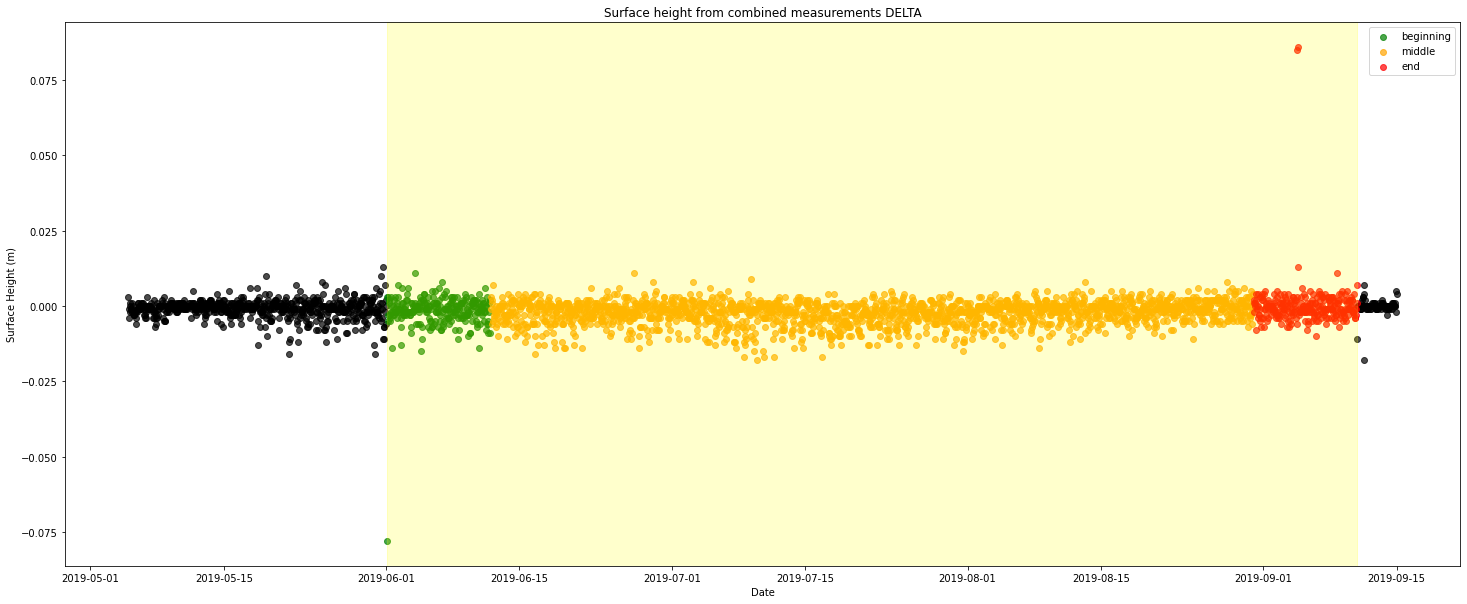

In [13]:
# Zooming in on one period
plt_srf_height(Period = ["2019-05-05", "2019-09-15"], y = df['Surface height from combined measurements DELTA'])

In [28]:
#### Save df 
xx = df 

In [27]:
df = xx

In [29]:
# This bit to only focus on the time where we see Ice Ablation
df = df[df["Ablation"] == True]

**Exploration**

In [22]:
pd.set_option('display.max_rows', None)
pd.DataFrame(df.isna().sum(), columns = ["Sum of missing values"])

,Sum of missing values
index,0
stid,0
Air pressure (upper boom),4
Air temperature (upper boom),4
Relative humidity (upper boom),4
Relative humidity (upper boom) - corrected,4
Specific humidity (upper boom),6
Wind speed (upper boom),89
Wind from direction (upper boom),89
Downwelling shortwave radiation,4


In [ ]:
pd.set_option('display.max_rows', 5)

#### Correlation and Pairplot (takes long time to run for many variables)

In [6]:
df.columns

Index([                                                             'index',
                                                                     'stid',
                                                'Air pressure (upper boom)',
                                             'Air temperature (upper boom)',
                                           'Relative humidity (upper boom)',
                               'Relative humidity (upper boom) - corrected',
                                           'Specific humidity (upper boom)',
                                                  'Wind speed (upper boom)',
                                         'Wind from direction (upper boom)',
                                          'Downwelling shortwave radiation',
                              'Downwelling shortwave radiation - corrected',
                                            'Upwelling shortwave radiation',
                                'Upwelling shortwave radiation - corrected',

In [16]:
# This bit to include only relevant features
exclude_list = [                                                    'index', # excluded because of unimportant information
                                                                     'stid', # excluded because of unimportant information
#                                                'Air pressure (upper boom)',
#                                             'Air temperature (upper boom)',
                                            'Relative humidity (upper boom)', # excluded because of corrected feature
#                               'Relative humidity (upper boom) - corrected',
#                                           'Specific humidity (upper boom)',
#                                                  'Wind speed (upper boom)',
#                                         'Wind from direction (upper boom)',
                                          'Downwelling shortwave radiation', # excluded because of corrected feature
#                              'Downwelling shortwave radiation - corrected',
                                            'Upwelling shortwave radiation', # excluded because of corrected feature
#                                'Upwelling shortwave radiation - corrected',
                                                                   'Albedo', # excluded due to missing values
#                                           'Downwelling longwave radiation',
#                                             'Upwelling longwave radiation',
#                                                              'Cloud cover',
#                                                      'Surface temperature',
                                            'Latent heat flux (upper boom)', # excluded due to missing values
                                          'Sensible heat flux (upper boom)', # excluded due to missing values
                                                        'Upper boom height', # excluded because of unimportant information
                                                             'Stake height', # excluded due to missing values
                                      'Depth of pressure transducer in ice', # excluded due to derived correlation with y
                          'Depth of pressure transducer in ice - corrected', # excluded due to derived correlation with y
                   'Precipitation (upper boom) (cumulative solid & liquid)', # excluded because of corrected feature
#       'Precipitation (upper boom) (cumulative solid & liquid) – corrected',
                                              'Ice temperature at sensor 1', # excluded due to missing values
                                              'Ice temperature at sensor 2', # excluded due to missing values
                                              'Ice temperature at sensor 3', # excluded due to missing values
                                              'Ice temperature at sensor 4', # excluded due to missing values
                                              'Ice temperature at sensor 5', # excluded due to missing values
                                              'Ice temperature at sensor 6', # excluded due to missing values
                                              'Ice temperature at sensor 7', # excluded due to missing values
                                              'Ice temperature at sensor 8', # excluded due to missing values
                                                             'Tilt to east', # excluded because of unimportant information 
                                                            'Tilt to north', # excluded because of unimportant information
                                         'Station rotation from true North', # excluded because of unimportant information
                                                                 'Latitude', # excluded because of unimportant information
                                                                'Longitude', # excluded because of unimportant information
                                                                 'Altitude', # excluded because of unimportant information
                                                                 'GPS time', # excluded because of unimportant information 
                               'Height of EGM96 geoid over WGS84 ellipsoid', # excluded because of unimportant information
                                                                  'GeoUnit', # excluded because of unimportant information
                             'GPS horizontal dillution of precision (HDOP)', # excluded because of unimportant information
                                                 'GPS number of satellites', # excluded because of unimportant information
                                                                  'Quality', # excluded because of unimportant information
                                                          'Battery voltage', # excluded because of unimportant information
                                                                    #    nan,
                                           'Battery voltage (sample start)', # excluded because of unimportant information
                                                 'Fan current (upper boom)', # excluded because of unimportant information
                       'Frequency of vibrating wire in precipitation gauge', # excluded because of unimportant information
                                                       'Logger temperature', # excluded because of unimportant information
                                             'Radiation sensor temperature', # excluded because of unimportant information
                                         'latitude from modem (email text)', # excluded because of unimportant information
                                        'longitude from modem (email text)', # excluded because of unimportant information
                                                         'Surface height 1', # excluded due to derived correlation with y
                                                         'Surface height 1', # excluded due to derived correlation with y
                                                        'z_surf_1_adj_flag', # excluded due to derived correlation with y
                                                        'z_surf_2_adj_flag', # excluded due to derived correlation with y
#                                'Surface height from combined measurements', 
                                   'Depth of ice temperature measurement 1', # excluded because of unimportant information
                                   'Depth of ice temperature measurement 2', # excluded because of unimportant information
                                   'Depth of ice temperature measurement 3', # excluded because of unimportant information
                                   'Depth of ice temperature measurement 4', # excluded because of unimportant information
                                   'Depth of ice temperature measurement 5', # excluded because of unimportant information
                                   'Depth of ice temperature measurement 6', # excluded because of unimportant information
                                   'Depth of ice temperature measurement 7', # excluded because of unimportant information
                                   'Depth of ice temperature measurement 8', # excluded because of unimportant information
                               'Ice temperature interpolated at 10 m depth', # excluded due to missing values
                                                'Air pressure (lower boom)', # excluded due to missing values
                                             'Air temperature (lower boom)', # excluded due to missing values
                                           'Relative humidity (lower boom)', # excluded due to missing values
                               'Relative humidity (lower boom) - corrected', # excluded due to missing values
                                           'Specific humidity (lower boom)', # excluded due to missing values
                                                  'Wind speed (lower boom)', # excluded due to missing values
                                         'Wind from direction (lower boom)', # excluded due to missing values
                                            'Latent heat flux (lower boom)', # excluded due to missing values
                                          'Sensible heat flux (lower boom)', # excluded due to missing values
                                                        'Lower boom height', # excluded due to missing values
                   'Precipitation (lower boom) (cumulative solid & liquid)', # excluded due to missing values
       'Precipitation (lower boom) (cumulative solid & liquid) – corrected', # excluded due to missing values
                                              'Ice temperature at sensor 9', # excluded due to missing values
                                             'Ice temperature at sensor 10', # excluded due to missing values
                                             'Ice temperature at sensor 11', # excluded due to missing values
                                                 'Fan current (lower boom)', # excluded due to missing values
                                   'Depth of ice temperature measurement 9', # excluded due to missing values
                                  'Depth of ice temperature measurement 10', # excluded due to missing values
                                  'Depth of ice temperature measurement 11', # excluded due to missing values
                                                        'z_pt_cor_adj_flag', # excluded due to derived correlation with y
                              'Ice surface height adjusted for maintenance', # excluded due to derived correlation with y
                                'Surface height adjusted for maintenance 1', # excluded due to derived correlation with y
                                  'Surface height adjusted for maintenance', # excluded due to derived correlation with y
#                                                                 'Datetime',
                                                                 'Ablation',  # excluded due to derived correlation with y
                          'Surface height from combined measurements DELTA'  # excluded due to derived correlation with y
                                                       
               ]

exclude = df[[column for column in df.columns if column not in exclude_list and not isinstance(column, int)]]
exclude = exclude.dropna(axis=1,how='all') 

KeyboardInterrupt: 

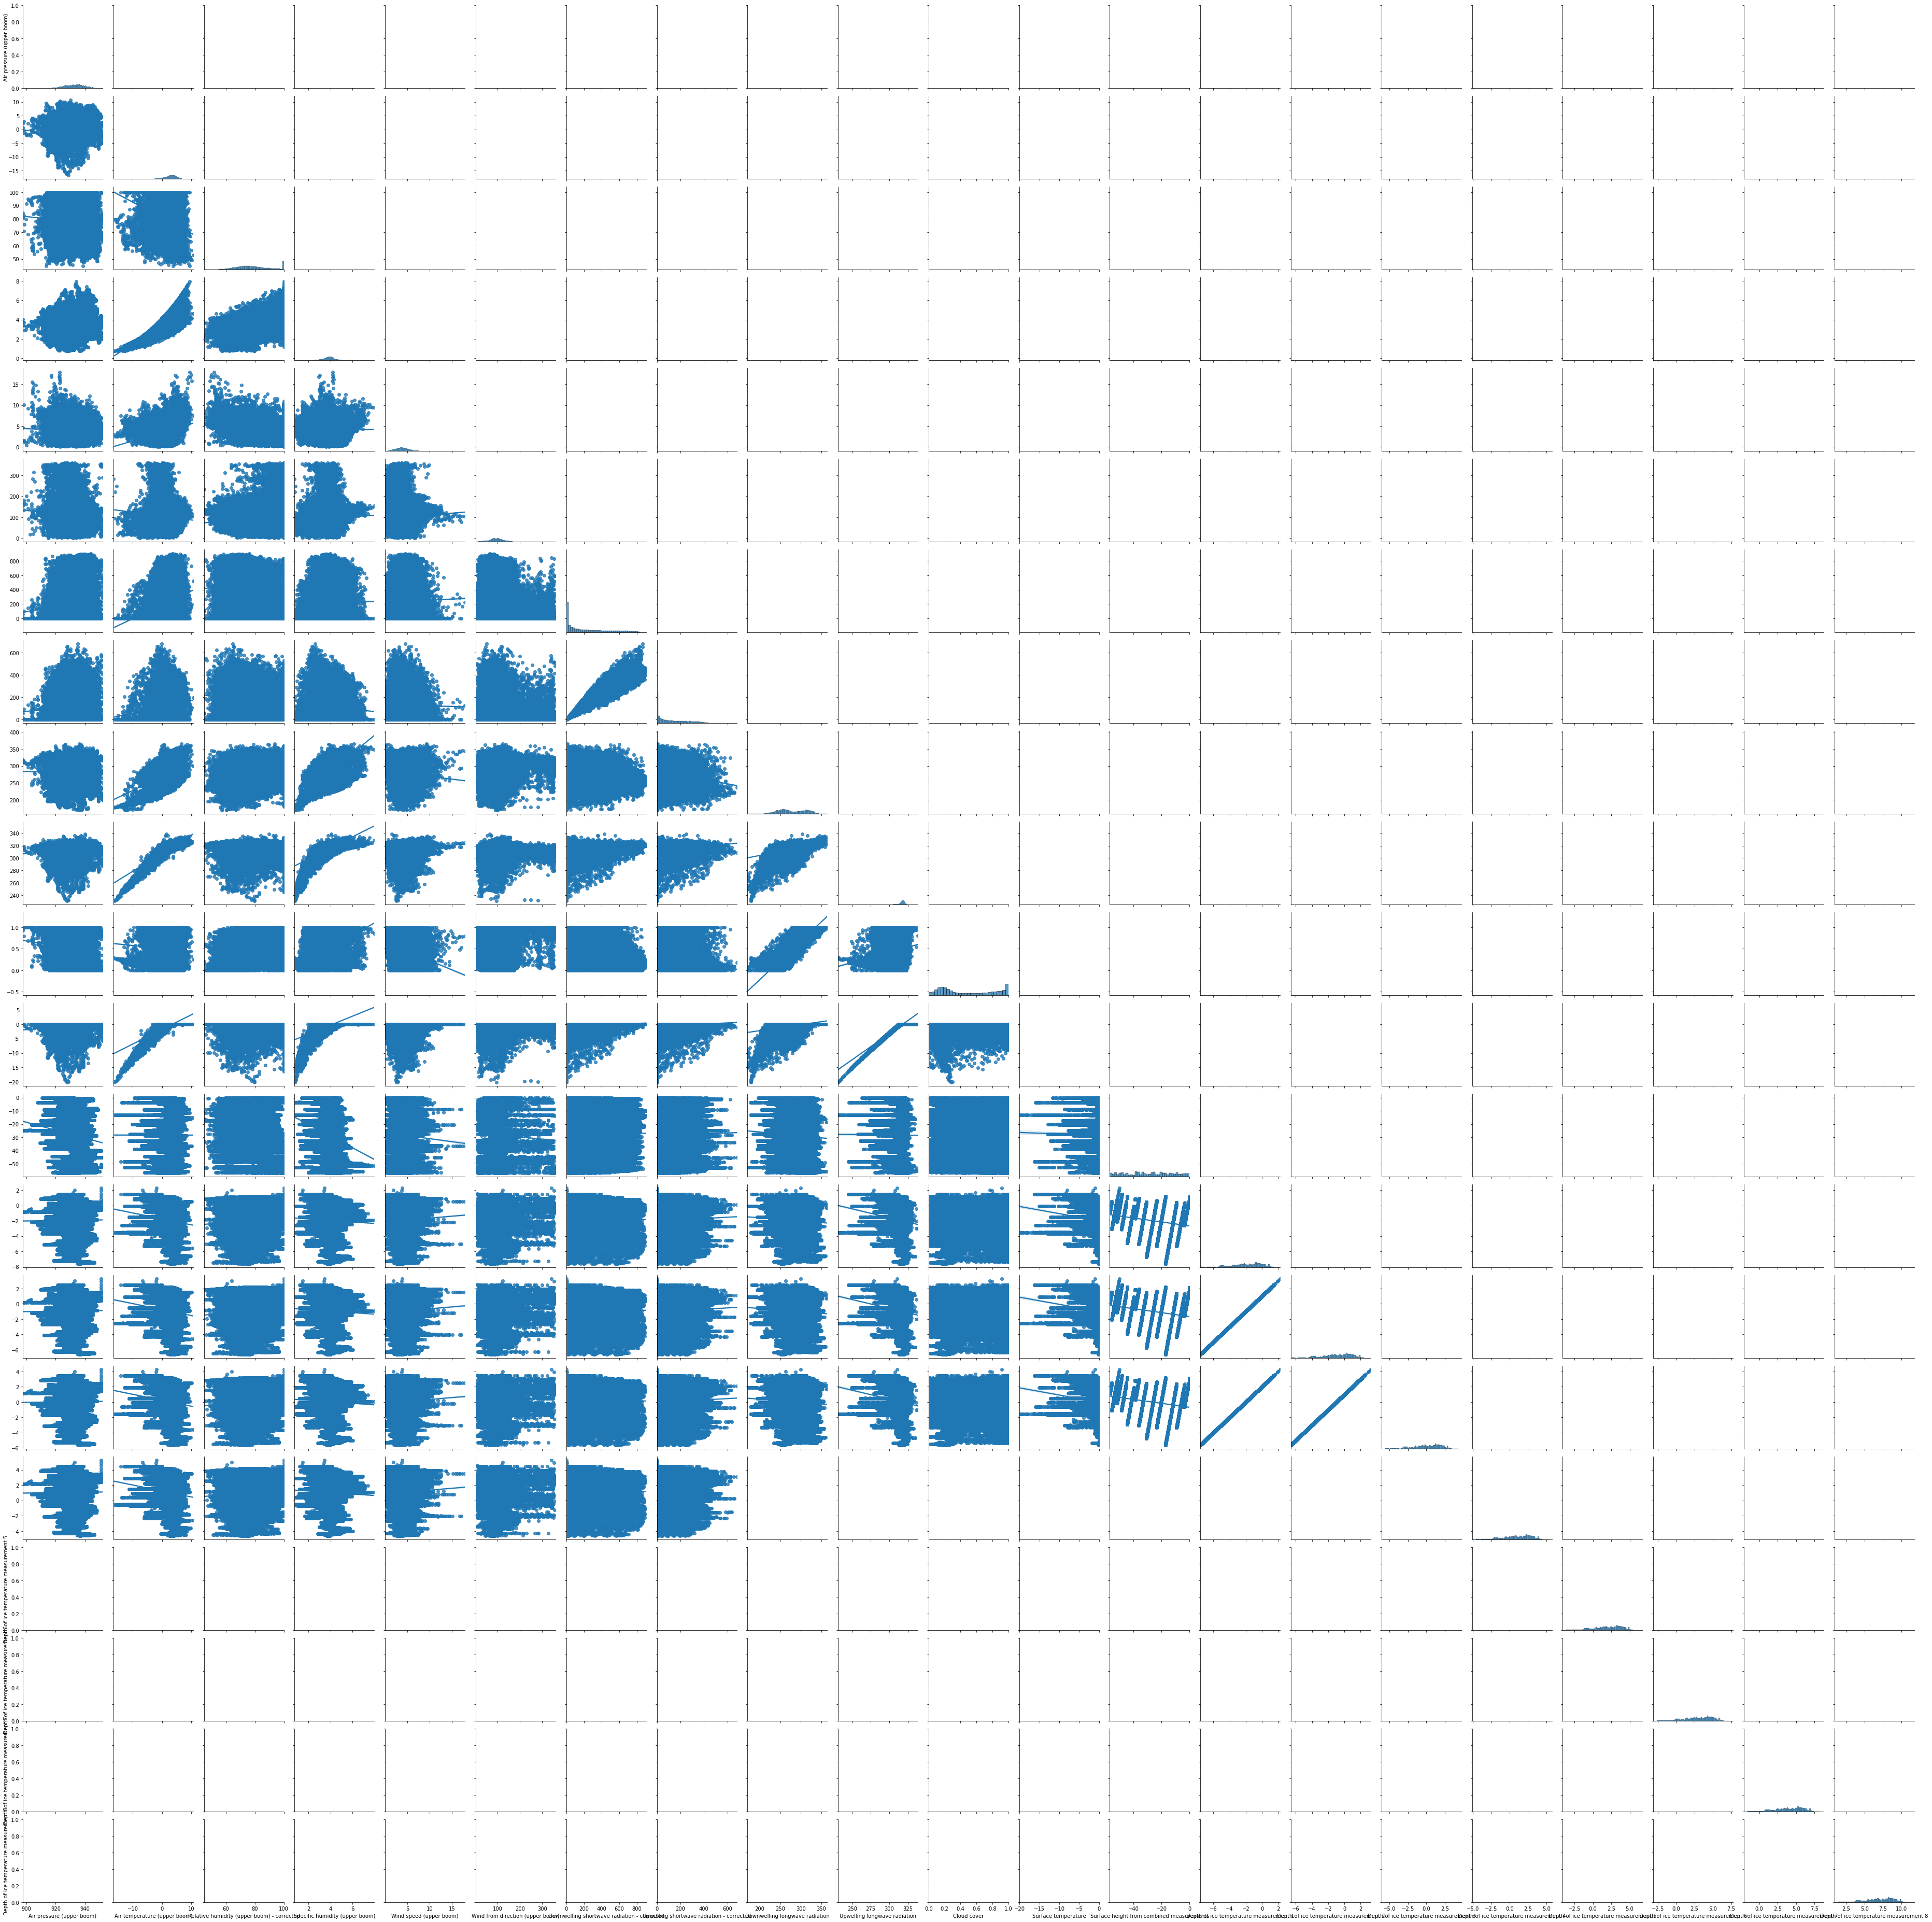

In [21]:
# Do not run

#sns.pairplot(data = exclude, kind='reg')

In [ ]:
# Heatmap
plt.figure(figsize=(16, 6))

heatmap = sns.heatmap(exclude.corr(), annot = True, vmin=-1, vmax=1, center= 0, cmap= 'coolwarm', linewidths=3, linecolor='black')

heatmap.set_title('Correlation Heatmap')


In [74]:
# Correlation with target variable only

corr_matrix = exclude.corr()
pd.DataFrame(corr_matrix["Surface height from combined measurements"].sort_values(ascending=False))

/var/folders/_r/2f7t_cz14232jqp3576_p04m0000gn/T/ipykernel_44029/3315904290.py:3: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = exclude.corr()


,Surface height from combined measurements
Surface height from combined measurements,1.000
Downwelling shortwave radiation - corrected,0.032
Upwelling shortwave radiation - corrected,0.027
Air temperature (upper boom),-0.000
Upwelling longwave radiation,-0.003
Surface temperature,-0.011
Wind from direction (upper boom),-0.048
Wind speed (upper boom),-0.049
Downwelling longwave radiation,-0.061
Cloud cover,-0.066


# Modelling

##### Pre-processing

In [30]:
# This bit retrieve the indexes for all melting season categories and remove column from df
for category in ['beginning', 'middle', 'end']:
    exec(f"indices_{category} = df[df['Melting Season'] == '{category}'].index")

df.drop(columns=['Melting Season'], inplace=True) 

/var/folders/_r/2f7t_cz14232jqp3576_p04m0000gn/T/ipykernel_52346/3707701489.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.drop(columns=['Melting Season'], inplace=True)


In [31]:
# This bit to include only relevant columns 

df = df[[column for column in df.columns if column not in exclude_list]]
df = df.dropna(axis=1,how='all') 

In [32]:
# This bit to change the datetime variables into a form that a ML models can understand
  # https://ianlondon.github.io/blog/encoding-cyclical-features-24hour-time/
  # https://feature-engine.trainindata.com/en/1.3.x/user_guide/creation/CyclicalFeatures.html
    
    
# This bit to split Datetime column into year, month, day, hour columns
df['Datetime'] = pd.to_datetime(df['Datetime'])
df['Datetime'] = df['Datetime'].dt.strftime('%Y-%m-%d %H:%M:%S')

df['Datetime'] = pd.to_datetime(df['Datetime'])

#Create new columns
df['year'] = df['Datetime'].dt.year # Maybe we need to exclude year???
df['month'] = df['Datetime'].dt.month
df['day'] = df['Datetime'].dt.day
df['hour'] = df['Datetime'].dt.hour

#Drop the datetime column
df.drop(columns=['Datetime'], inplace=True)

# Use CyclicalFeatures Package to convert year, month, day & hour
from feature_engine.creation import CyclicalFeatures

cyclical = CyclicalFeatures(variables=None, drop_original=True)

#cyclical = cyclical.fit_transform(df[['year', 'month','day', 'hour']])
cyclical = cyclical.fit_transform(df[['month','day', 'hour']])
df = pd.merge(df, cyclical, left_index=True, right_index=True)
df.drop(columns=['year', 'month','day', 'hour'], inplace=True)

In [33]:
# This bit to convert all numerical values into the same scale 
from sklearn.preprocessing import MinMaxScaler

num_cols = df.select_dtypes(include=['int64','float64']).columns #select numerical columns

scaler = MinMaxScaler()

#fit and transform numerical columns
df[num_cols] = scaler.fit_transform(df[num_cols])

In [34]:
# This bit to split into Train & Test
from sklearn.model_selection import train_test_split

X= df.loc[:, df.columns != "Surface height from combined measurements"] # All features except y
y=df["Surface height from combined measurements"]

# using the train test split function
X_train, X_test,y_train, y_test = train_test_split(X,y ,
                                   random_state=2023, 
                                   test_size=0.3, 
                                   shuffle=True)

**PCA** (We need to rethink if PCA is useful or not)

------------------------- With Imputation -----------------------------------------------------------------

In [31]:
# PCA does not allow missing values, we need to impute or exclude all NAN values..

# import the KNNimputer class
    #from sklearn.impute import KNNImputer
from sklearn.impute import SimpleImputer

# create an object for KNNImputer
    #imputer = KNNImputer(n_neighbors = 2)
imputer = SimpleImputer(missing_values=np.nan, strategy='mean')
X_train_imp = imputer.fit_transform(X_train)
X_test_imp = imputer.fit_transform(X_test)

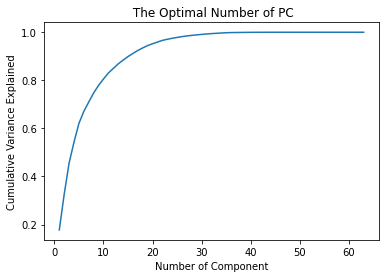

In [32]:
# Apply PCA
from sklearn.decomposition import PCA

pca = PCA()
X_train_imp = pca.fit_transform(X_train_imp)
X_test_imp = pca.transform(X_test_imp)

# visualizing the amount of variance data explained for each principle component
cumulative_variance_explained = np.cumsum(pca.explained_variance_ratio_)
x_values = list(range(1, len(cumulative_variance_explained)+1))

#plot the line graph explaining variance of feature variables through the components
plt.plot(x_values, cumulative_variance_explained)
plt.xlabel('Number of Component')
plt.ylabel('Cumulative Variance Explained')
plt.title(' The Optimal Number of PC')
plt.show()

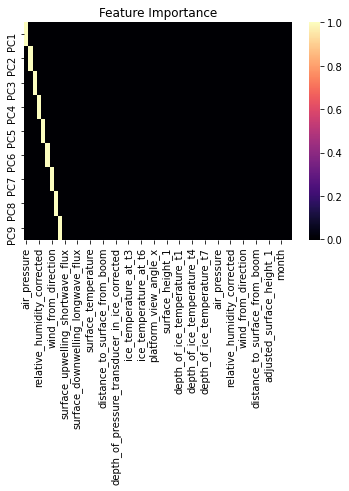

In [50]:
#Identify the optimal number of principal components 
optimal_component = np.argmax(cumulative_variance_explained >=0.8) + 1

columns = [f'PC{i}' for i in range(1, optimal_component + 1)]

#Transform data with the optimal number of components
pca = PCA(n_components = optimal_component)

X_train_pca = pca.fit_transform(X_train_imp)
X_test_pca = pca.transform(X_test_imp)

# see how much features contribute to which components
pca_df = pd.DataFrame(pca.components_,
                      columns= X_train.columns,
                      index = columns)
pca_df.head()

#plot a heatmap to visualise how the feature variables contribute to PC
sns.heatmap(pca_df,cmap ='magma')
plt.title('Feature Importance')
plt.show()

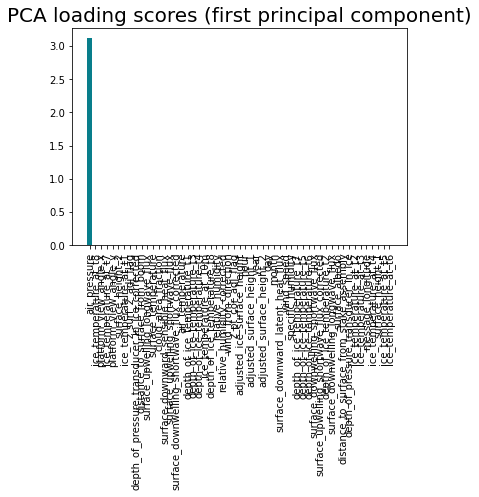

In [35]:
loadings = pd.DataFrame(
    data=pca.components_.T * np.sqrt(pca.explained_variance_), 
    columns= columns ,
    index=  X_train.columns
)

pc1_loadings = loadings.sort_values(by='PC1', ascending=False)[['PC1']]
pc1_loadings = pc1_loadings.reset_index()
pc1_loadings.columns = ['Attribute', 'CorrelationWithPC1']

plt.bar(x=pc1_loadings['Attribute'], height=pc1_loadings['CorrelationWithPC1'], color='#087E8B')
plt.title('PCA loading scores (first principal component)', size=20)
plt.xticks(rotation='vertical')
plt.show()

-------------------------------- Without Imputation ---------------------------------------------------

In [48]:
#  We can follow this paper: https://www.sciencedirect.com/science/article/pii/S1574954121000261#:~:text=The%20standard%20algorithm%20of%20PCA%20is%20modified%20to%20accommodate%20incomplete%20data.&text=The%20method%20produces%20ordination%20scores%20for%20variables%20and%20observations%20simultaneously.&text=Information%20is%20maximally%20exhausted%2C%20while%20data%20imputation%20is%20not%20required.
# Or: https://github.com/allentran/pca-magic

import os

import numpy as np
from scipy.linalg import orth


class PPCA():

    def __init__(self):

        self.raw = None
        self.data = None
        self.C = None
        self.means = None
        self.stds = None
        self.eig_vals = None

    def _standardize(self, X):

        if self.means is None or self.stds is None:
            raise RuntimeError("Fit model first")

        return (X - self.means) / self.stds

    def fit(self, data, d=None, tol=1e-4, min_obs=10, verbose=False):

        self.raw = data
        self.raw[np.isinf(self.raw)] = np.max(self.raw[np.isfinite(self.raw)])

        valid_series = np.sum(~np.isnan(self.raw), axis=0) >= min_obs

        data = self.raw[:, valid_series].copy()
        N = data.shape[0]
        D = data.shape[1]

        self.means = np.nanmean(data, axis=0)
        self.stds = np.nanstd(data, axis=0)

        data = self._standardize(data)
        observed = ~np.isnan(data)
        missing = np.sum(~observed)
        data[~observed] = 0

        # initial

        if d is None:
            d = data.shape[1]
        
        if self.C is None:
            C = np.random.randn(D, d)
        else:
            C = self.C
        CC = np.dot(C.T, C)
        X = np.dot(np.dot(data, C), np.linalg.inv(CC))
        recon = np.dot(X, C.T)
        recon[~observed] = 0
        ss = np.sum((recon - data)**2)/(N*D - missing)

        v0 = np.inf
        counter = 0

        while True:

            Sx = np.linalg.inv(np.eye(d) + CC/ss)

            # e-step
            ss0 = ss
            if missing > 0:
                proj = np.dot(X, C.T)
                data[~observed] = proj[~observed]
            X = np.dot(np.dot(data, C), Sx) / ss

            # m-step
            XX = np.dot(X.T, X)
            C = np.dot(np.dot(data.T, X), np.linalg.pinv(XX + N*Sx))
            CC = np.dot(C.T, C)
            recon = np.dot(X, C.T)
            recon[~observed] = 0
            ss = (np.sum((recon-data)**2) + N*np.sum(CC*Sx) + missing*ss0)/(N*D)

            # calc diff for convergence
            det = np.log(np.linalg.det(Sx))
            if np.isinf(det):
                det = abs(np.linalg.slogdet(Sx)[1])
            v1 = N*(D*np.log(ss) + np.trace(Sx) - det) \
                + np.trace(XX) - missing*np.log(ss0)
            diff = abs(v1/v0 - 1)
            if verbose:
                print(diff)
            if (diff < tol) and (counter > 5):
                break

            counter += 1
            v0 = v1


        C = orth(C)
        vals, vecs = np.linalg.eig(np.cov(np.dot(data, C).T))
        order = np.flipud(np.argsort(vals))
        vecs = vecs[:, order]
        vals = vals[order]

        C = np.dot(C, vecs)

        # attach objects to class
        self.C = C
        self.data = data
        self.eig_vals = vals
        self._calc_var()

    def transform(self, data=None):

        if self.C is None:
            raise RuntimeError('Fit the data model first.')
        if data is None:
            return np.dot(self.data, self.C)
        return np.dot(data, self.C)

    def _calc_var(self):

        if self.data is None:
            raise RuntimeError('Fit the data model first.')

        data = self.data.T

        # variance calc
        var = np.nanvar(data, axis=1)
        total_var = var.sum()
        self.var_exp = self.eig_vals.cumsum() / total_var

    def save(self, fpath):

        np.save(fpath, self.C)
        
    def load(self, fpath):

        assert os.path.isfile(fpath)

        self.C = np.load(fpath)

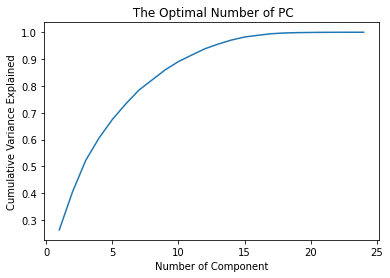

In [49]:
ppca = PPCA()

ppca.fit(data = X_train.to_numpy(), d=30)

# visualizing the amount of variance data explained for each principle component
cumulative_variance_explained = ppca.var_exp
x_values = list(range(1, len(cumulative_variance_explained)+1))

#plot the line graph explaining variance of feature variables through the components
plt.plot(x_values, cumulative_variance_explained)
plt.xlabel('Number of Component')
plt.ylabel('Cumulative Variance Explained')
plt.title(' The Optimal Number of PC')
plt.show()


Text(0.5, 1.0, 'Correlation Heatmap')

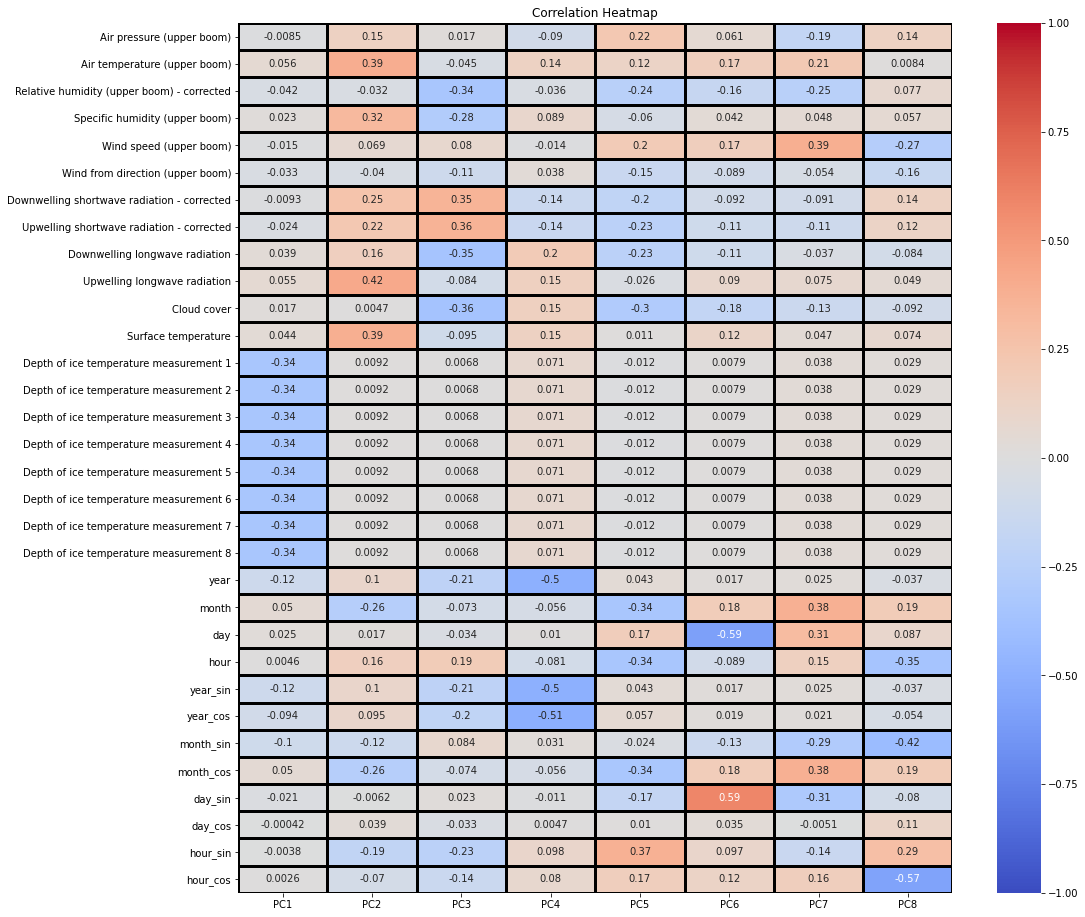

In [54]:
#Identify the optimal number of principal components 
optimal_component = np.argmax(cumulative_variance_explained >=0.8) + 1

columns = [f'PC{i}' for i in range(1, optimal_component + 1)]

ppca = PPCA()

X_train_ppca = ppca.fit(data = X_train.to_numpy(), d=optimal_component) 
X_train_ppca = ppca.transform(X_train_ppca)
X_test_ppca = ppca.transform(X_test.to_numpy())

# see how much features contribute to which components
ppca_df = pd.DataFrame(ppca.C,
                       columns = columns,
                       index =X_train.columns)
ppca_df.head()

#plot a heatmap to visualise how the feature variables contribute to PC
# Heatmap
plt.figure(figsize=(16, 16))

heatmap = sns.heatmap(ppca_df, annot = True, vmin=-1, vmax=1, center= 0, cmap= 'coolwarm', linewidths=3, linecolor='black')

heatmap.set_title('Correlation Heatmap')


**XGB Regression**

In [35]:
# Import required libraries
import xgboost as xgb
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV

# Define the XGBRegressor model
model = xgb.XGBRegressor()

# Define the hyperparameter grid for tuning
param_grid = {
    'max_depth': [3], #[3, 5, 7],
    'min_child_weight': [1], #[1, 3, 5],
    'learning_rate': [0.1], #[0.1, 0.01, 0.001],
    'n_estimators': [100], #[100, 500, 1000],
    'subsample': [0.5], #[0.5, 0.7, 1.0],
    'colsample_bytree': [0.7], #[0.5, 0.7, 1.0],
    'reg_alpha': [0.1], #[0, 0.1, 0.5],
    'reg_lambda': [0.1], #[0, 0.1, 0.5]
}

# Define the grid search object
grid_search = GridSearchCV(model, param_grid = param_grid, cv=5, n_jobs=-1, verbose=2)

# Fit the grid search object to the training data
grid_search.fit(X_train, y_train)

# Print the best hyperparameters and the corresponding R^2 score on the test set
print("Best hyperparameters: ", grid_search.best_params_)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Best hyperparameters:  {'colsample_bytree': 0.7, 'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 100, 'reg_alpha': 0.1, 'reg_lambda': 0.1, 'subsample': 0.5}


R^2 score on test set:  0.3739086205082238
MSE on test set:  0.05102445026595613
                                        Feature  Importance
0    Relative humidity (upper boom) - corrected    0.197698
1                Specific humidity (upper boom)    0.101478
2                       Wind speed (upper boom)    0.073323
3                     Air pressure (upper boom)    0.070550
4                  Upwelling longwave radiation    0.067414
5                                     month_cos    0.064559
6              Wind from direction (upper boom)    0.054312
7                                   Cloud cover    0.048520
8                  Air temperature (upper boom)    0.047975
9                           Surface temperature    0.044626
10                                      day_cos    0.041465
11  Downwelling shortwave radiation - corrected    0.040944
12                                     hour_cos    0.039637
13               Downwelling longwave radiation    0.029377
14                 

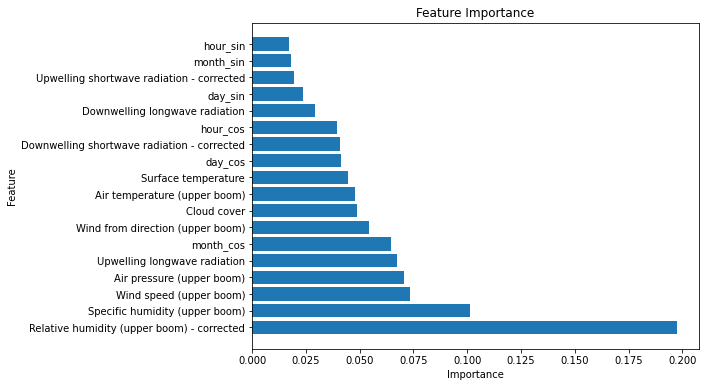

In [36]:
y_pred = grid_search.predict(X_test)
r2 = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
print("R^2 score on test set: ", r2)
print("MSE on test set: ", mse)

# Get the feature importance scores and plot them
feature_importance = pd.DataFrame({'Feature': X_train.columns, 'Importance': grid_search.best_estimator_.feature_importances_})
feature_importance = feature_importance.sort_values('Importance', ascending=False).reset_index(drop=True)
print(feature_importance)

# Plot the feature importance scores
import matplotlib.pyplot as plt
plt.figure(figsize=(8, 6))
plt.barh(feature_importance['Feature'], feature_importance['Importance'])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance')
plt.show()

#### Nils: I am trying to filter on the different melting seasons to then fit XGB regressor three times to see the different feature importances.

Fitting 5 folds for each of 1 candidates, totalling 5 fits
R^2 score on test set (beginning):  0.6068764538031377
MSE on test set (beginning):  0.03181108088741442
                                        Feature  Importance
0    Relative humidity (upper boom) - corrected    0.168355
1                                     month_cos    0.111851
2                  Upwelling longwave radiation    0.076506
3                Downwelling longwave radiation    0.075667
4                Specific humidity (upper boom)    0.063253
5                     Air pressure (upper boom)    0.063181
6                                   Cloud cover    0.058579
7                                       day_cos    0.052876
8                  Air temperature (upper boom)    0.051229
9              Wind from direction (upper boom)    0.048332
10                                      day_sin    0.046862
11                                     hour_sin    0.040370
12                      Wind speed (upper boom)    0.036

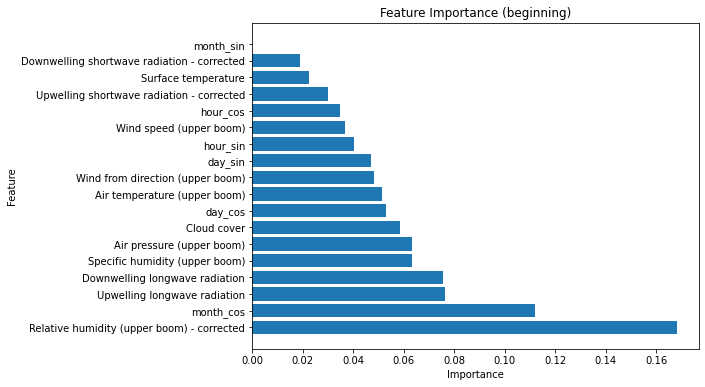

Fitting 5 folds for each of 1 candidates, totalling 5 fits
R^2 score on test set (middle):  0.386480353194126
MSE on test set (middle):  0.04964665092211201
                                        Feature  Importance
0    Relative humidity (upper boom) - corrected    0.187991
1                Specific humidity (upper boom)    0.121353
2                       Wind speed (upper boom)    0.076479
3                     Air pressure (upper boom)    0.076301
4              Wind from direction (upper boom)    0.058020
5                  Upwelling longwave radiation    0.056241
6                                     month_cos    0.050464
7                  Air temperature (upper boom)    0.048190
8                                       day_cos    0.046867
9                                   Cloud cover    0.042544
10                          Surface temperature    0.034418
11                                     hour_cos    0.033081
12               Downwelling longwave radiation    0.031779
13 

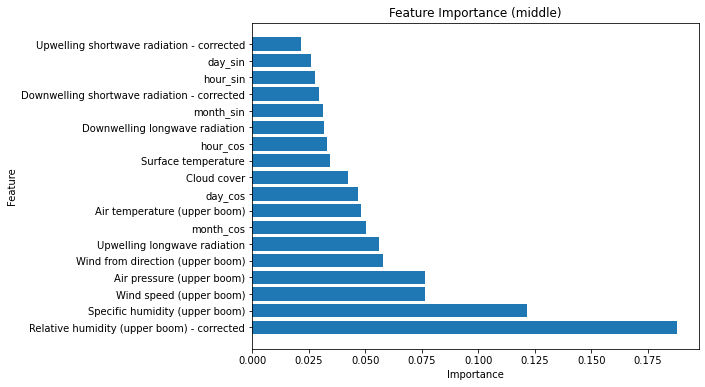

Fitting 5 folds for each of 1 candidates, totalling 5 fits
R^2 score on test set (end):  0.6922134427377019
MSE on test set (end):  0.02600956148166889
                                        Feature  Importance
0                                     month_cos    0.195684
1                                     month_sin    0.157611
2    Relative humidity (upper boom) - corrected    0.108544
3                Specific humidity (upper boom)    0.078069
4                     Air pressure (upper boom)    0.067870
5                                       day_sin    0.066551
6                                       day_cos    0.062241
7                  Upwelling longwave radiation    0.041677
8                       Wind speed (upper boom)    0.034496
9                           Surface temperature    0.032795
10                 Air temperature (upper boom)    0.030230
11               Downwelling longwave radiation    0.028574
12             Wind from direction (upper boom)    0.026903
13      

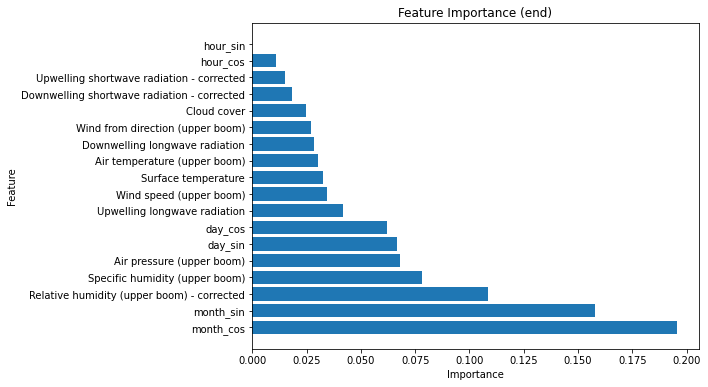

[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=3, min_child_weight=1, n_estimators=100, reg_alpha=0.1, reg_lambda=0.1, subsample=0.5; total time=   4.1s
[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=3, min_child_weight=1, n_estimators=100, reg_alpha=0.1, reg_lambda=0.1, subsample=0.5; total time=   4.1s
[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=3, min_child_weight=1, n_estimators=100, reg_alpha=0.1, reg_lambda=0.1, subsample=0.5; total time=   3.0s
[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=3, min_child_weight=1, n_estimators=100, reg_alpha=0.1, reg_lambda=0.1, subsample=0.5; total time=   0.3s
[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=3, min_child_weight=1, n_estimators=100, reg_alpha=0.1, reg_lambda=0.1, subsample=0.5; total time=   3.0s
[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=3, min_child_weight=1, n_estimators=100, reg_alpha=0.1, reg_lambda=0.1, subsample=0.5; total time=   4.2s
[CV]

In [37]:
for category in ['beginning', 'middle', 'end']:
    indices = eval(f"indices_{category}")  # Get the indices for the current category
    
    # Find common indexes
    X_Train_valid_indices = indices.intersection(X_train.index)
    y_Train_valid_indices = indices.intersection(y_train.index)
    X_Test_valid_indices = indices.intersection(X_test.index)
    y_Test_valid_indices = indices.intersection(y_test.index)
    
    # filter out by indeces
    X_train_category = X_train.loc[X_Train_valid_indices]  
    y_train_category = y_train.loc[y_Train_valid_indices] 
    X_test_category = X_test.loc[X_Test_valid_indices]  
    y_test_category = y_test.loc[y_Test_valid_indices]  
    
    # Apply XGB on all periods
    grid_search.fit(X_train_category, y_train_category)
    
    y_pred_category = grid_search.predict(X_test_category)
    r2 = r2_score(y_test_category, y_pred_category)
    mse = mean_squared_error(y_test_category, y_pred_category)
    print(f"R^2 score on test set ({category}): ", r2)
    print(f"MSE on test set ({category}): ", mse)
    feature_importance = grid_search.best_estimator_.feature_importances_

    # Get the feature importance scores and plot them
    feature_importance = pd.DataFrame({'Feature': X_train.columns, 'Importance': grid_search.best_estimator_.feature_importances_})
    feature_importance = feature_importance.sort_values('Importance', ascending=False).reset_index(drop=True)
    print(feature_importance)

    # Plot the feature importance scores
    import matplotlib.pyplot as plt
    plt.figure(figsize=(8, 6))
    plt.barh(feature_importance['Feature'], feature_importance['Importance'])
    plt.xlabel('Importance')
    plt.ylabel('Feature')
    plt.title(f'Feature Importance ({category})')
    plt.show()

In [191]:
for category in ['beginning', 'middle', 'end']:
    indices = eval(f"indices_{category}")  # Get the indices for the current category
    valid_indices = set(indices).intersection(X_test.index).intersection(y_test.index)
    # Filter X_test and y_test by the current category's valid indices
    X_test_category = X_test.loc[valid_indices]
    y_test_category = y_test.loc[valid_indices]
    print(f"Results for {category} category:")

Results for beginning category:
Results for middle category:
Results for end category:


/var/folders/_r/2f7t_cz14232jqp3576_p04m0000gn/T/ipykernel_46484/3691237972.py:5: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  X_test_category = X_test.loc[valid_indices]
/var/folders/_r/2f7t_cz14232jqp3576_p04m0000gn/T/ipykernel_46484/3691237972.py:6: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  y_test_category = y_test.loc[valid_indices]
/var/folders/_r/2f7t_cz14232jqp3576_p04m0000gn/T/ipykernel_46484/3691237972.py:5: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  X_test_category = X_test.loc[valid_indices]
/var/folders/_r/2f7t_cz14232jqp3576_p04m0000gn/T/ipykernel_46484/3691237972.py:6: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  y_test_category = y_test.loc[valid_indices]
/var/folders/_r/2f7t_cz14232jqp3576_

## Test Suite

--------

In [64]:
from xgboost import XGBRegressor

model = XGBRegressor()

X_train = X_train.loc[:,~X_train.columns.duplicated()]
model.fit(X_train, y_train)

np.set_printoptions(formatter={'float_kind':'{:f}'.format})
pd.set_option('display.float_format', lambda x: '%.3f' % x)

importances = pd.DataFrame(data={
    'Attribute': X_train.columns,
    'Importance': model.feature_importances_
})
importances = importances.sort_values(by='Importance', ascending=False)

In [65]:
importances

,Attribute,Importance
20,year,0.996
21,month,0.003
12,Depth of ice temperature measurement 1,0.001
22,day,0.000
26,month_sin,0.000
0,Air pressure (upper boom),0.000
28,day_sin,0.000
29,day_cos,0.000
23,hour,0.000
3,Specific humidity (upper boom),0.000


**Linear Regression**

<function matplotlib.pyplot.xticks(ticks=None, labels=None, **kwargs)>

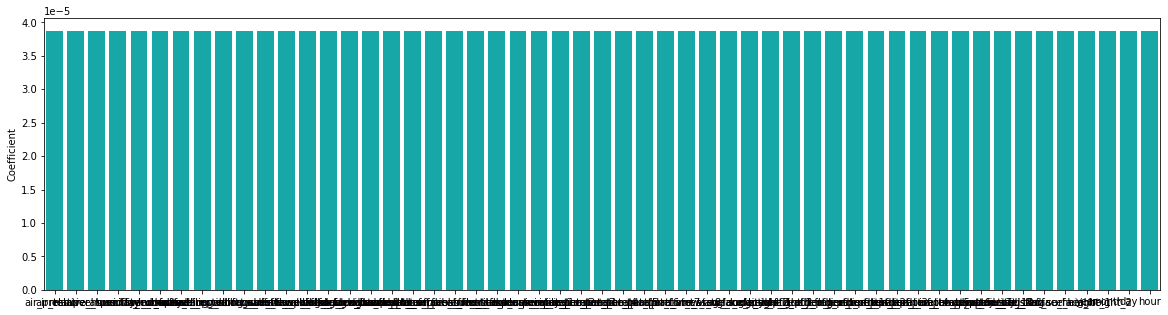

In [101]:
#import linear regression model from scikit-learn library
from sklearn.linear_model import LinearRegression

#import libraries for visualization
import matplotlib as mp

#instantiate the LinearRegression model 
lm = LinearRegression()

#fit the model to our data
lm.fit(X_train_imp,y_train)

#obtain the coefficients 
coefficients = pd.DataFrame({'Coefficient':lm.coef_[0]}, index=X_train.columns)

#visualize the coefficients 
plt.figure(figsize=(20,5))
sns.barplot(x=coefficients.index, y="Coefficient",data=coefficients,
            color="c")
plt.xticks

**KNN Regression**

In [85]:
from sklearn.neighbors import KNeighborsRegressor
model = KNeighborsRegressor(n_neighbors=5)
model.fit(X_train, y_train)



ValueError: Input X contains NaN.
KNeighborsRegressor does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values. See https://scikit-learn.org/stable/modules/impute.html You can find a list of all estimators that handle NaN values at the following page: https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values